In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import pysam
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from utils.util_lift_over import liftover

if not os.getcwd().endswith('cfdna_snv_benchmark'):
    os.chdir('../')
print('Current working directory: {}'.format(os.getcwd()))

Current working directory: /Users/hanae/Repositories/cfdna_snv_benchmark


In [2]:
target = 'noncoding'
if target == 'coding':
    cosmic_pd = pd.read_csv(os.path.join('data', 'extdata', 'CosmicMutantExport.tsv'), encoding='ISO-8859-1', sep='\t', memory_map=True)
else: # target == 'noncoding'
    cosmic_pd = pd.read_csv(os.path.join('data', 'extdata', 'CosmicNCV.tsv'), encoding='ISO-8859-1', sep='\t', memory_map=True)

print(cosmic_pd.shape)

(18788998, 28)


In [3]:
cosmic_pd.columns

Index(['Sample name', 'ID_SAMPLE', 'ID_tumour', 'Primary site',
       'Site subtype 1', 'Site subtype 2', 'Site subtype 3',
       'Primary histology', 'Histology subtype 1', 'Histology subtype 2',
       'Histology subtype 3', 'GENOMIC_MUTATION_ID', 'LEGACY_MUTATION_ID',
       'zygosity', 'GRCh', 'genome position', 'Mutation somatic status',
       'WT_SEQ', 'MUT_SEQ', 'FATHMM_MKL_NON_CODING_SCORE',
       'FATHMM_MKL_NON_CODING_GROUPS', 'FATHMM_MKL_CODING_SCORE',
       'FATHMM_MKL_CODING_GROUPS', 'Whole_Genome_Reseq', 'Whole_Exome',
       'ID_STUDY', 'PUBMED_PMID', 'HGVSG'],
      dtype='object')

## COLUMNS
['Gene name', 'Accession Number', 'Gene CDS length', 'HGNC ID',
'Sample name', 'ID_sample', 'ID_tumour', 'Primary site',
'Site subtype 1', 'Site subtype 2', 'Site subtype 3',
'Primary histology', 'Histology subtype 1', 'Histology subtype 2',
'Histology subtype 3', 'Genome-wide screen', 'GENOMIC_MUTATION_ID',
'LEGACY_MUTATION_ID', 'MUTATION_ID', 'Mutation CDS', 'Mutation AA',
'Mutation Description', 'Mutation zygosity', 'LOH', 'GRCh',
'Mutation genome position', 'Mutation strand', 'Resistance Mutation',
'FATHMM prediction', 'FATHMM score', 'Mutation somatic status',
'Pubmed_PMID', 'ID_STUDY', 'Sample Type', 'Tumour origin', 'Age',
'HGVSP', 'HGVSC', 'HGVSG']

## PRIMARY SITES
['breast' 'haematopoietic_and_lymphoid_tissue' 'lung' 'liver'
 'endometrium' 'upper_aerodigestive_tract' 'large_intestine' 'skin'
 'kidney' 'soft_tissue' 'ovary' 'central_nervous_system' 'biliary_tract'
 'stomach' 'oesophagus' 'prostate' 'urinary_tract' 'bone'
 'autonomic_ganglia' 'penis' 'uterine_adnexa' 'cervix' 'pancreas' 'NS'
 'testis' 'thyroid' 'pleura' 'placenta' 'meninges' 'small_intestine'
 'genital_tract' 'adrenal_gland' 'salivary_gland' 'thymus' 'peritoneum'
 'eye' 'parathyroid' 'pituitary'
 'gastrointestinal_tract_(site_indeterminate)'
 'female_genital_tract_(site_indeterminate)' 'vulva' 'fallopian_tube'
 'vagina' 'paratesticular_tissues' 'perineum' 'retroperitoneum'
 'pericardium' 'mediastinum' 'female_genitourinary_system']

In [4]:
cancer_type = 'CRC'
chrom = '22'

In [5]:
# cancer type selection
if cancer_type == 'CRC':
    if target == 'coding':
        cosmic_muts = cosmic_pd[(cosmic_pd['Primary site'] == 'large_intestine') & (cosmic_pd['Site subtype 1'] == 'colon') & (cosmic_pd['Tumour origin'] == 'primary')]
    else: # target == 'noncoding'
        cosmic_muts = cosmic_pd[(cosmic_pd['Primary site'] == 'large_intestine') & (cosmic_pd['Site subtype 1'] == 'colon')]

else:
    print('NEED TO INCLUDE THIS CANCER TYPE')
print(cosmic_muts.shape)

(297743, 28)


In [6]:
# annotate mutation type
cosmic_muts['type'] = np.nan
if target == 'coding':
    print(cosmic_muts['Mutation Description'].unique()) # SNV or INDEL
    cosmic_muts['type'][cosmic_muts['Mutation Description'].str.contains('Substitution') == True] = 'SNV'
    cosmic_muts['type'][cosmic_muts['Mutation Description'].str.contains('Insertion') == True] = 'INS'
    cosmic_muts['type'][cosmic_muts['Mutation Description'].str.contains('Deletion') == True] = 'DEL'
    cosmic_muts.dropna(subset=['type'], inplace=True)
else: # target == 'noncoding'
    cosmic_muts['type'][cosmic_muts['MUT_SEQ'].str.len()-cosmic_muts['WT_SEQ'].str.len() == 0] = 'SNV'
    cosmic_muts['type'][cosmic_muts['MUT_SEQ'].str.len()-cosmic_muts['WT_SEQ'].str.len() > 0] = 'INS'
    cosmic_muts['type'][cosmic_muts['MUT_SEQ'].str.len()-cosmic_muts['WT_SEQ'].str.len() < 0] = 'DEL'
print(cosmic_muts.shape)
cosmic_muts.head()

/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pa

(297743, 29)


/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,Sample name,ID_SAMPLE,ID_tumour,Primary site,Site subtype 1,Site subtype 2,Site subtype 3,Primary histology,Histology subtype 1,Histology subtype 2,...,FATHMM_MKL_NON_CODING_SCORE,FATHMM_MKL_NON_CODING_GROUPS,FATHMM_MKL_CODING_SCORE,FATHMM_MKL_CODING_GROUPS,Whole_Genome_Reseq,Whole_Exome,ID_STUDY,PUBMED_PMID,HGVSG,type
1,MSS3-a,2809968,2666630,large_intestine,colon,transverse,NS,adenoma,tubular,high_grade_dysplasia,...,0.90866,NaN,0.56856,NaN,n,y,NaN,26336987.0,3:g.49051329C>A,SNV
76,TCGA-AM-5821-01,1651151,1565938,large_intestine,colon,sigmoid,NS,carcinoma,adenocarcinoma,NS,...,0.40931,NaN,0.00684,NaN,n,y,376.0,NaN,16:g.81053830C>T,SNV
218,1517_CLM,2501001,2363352,large_intestine,colon,right,NS,carcinoma,adenocarcinoma,NS,...,0.71715,NaN,0.65593,NaN,n,y,NaN,26109429.0,17:g.45904542C>T,SNV
637,T473,2296250,2161853,large_intestine,colon,descending,NS,carcinoma,adenocarcinoma,NS,...,0.39984,NaN,0.24301,NaN,n,y,NaN,25344691.0,2:g.160053219C>T,SNV
676,T6,2411195,2274074,large_intestine,colon,NS,NS,carcinoma,adenocarcinoma,NS,...,0.06152,NaN,0.00313,NaN,n,y,NaN,26071483.0,6:g.150205612G>A,SNV


In [7]:
# encode mutation position
if target == 'coding':
    mutposname = 'Mutation genome position'
else: # target == 'noncoding'
    mutposname = 'genome position'
cosmic_muts['chrom'] = cosmic_muts[mutposname].str.split(':').str[0]
cosmic_muts['chrom'][cosmic_muts['chrom'] == 23] = 'X'
cosmic_muts['chrom'][cosmic_muts['chrom'] == 24] = 'Y'
cosmic_muts['chrom'] = 'chr'+cosmic_muts['chrom']
cosmic_muts['startpos'] = cosmic_muts[mutposname].str.split(':').str[1].str.split('-').str[0]
cosmic_muts['endpos'] = cosmic_muts[mutposname].str.split(':').str[1].str.split('-').str[1]
cosmic_muts['chrom_pos'] = cosmic_muts['chrom'] + '_' + cosmic_muts['startpos'] + '_' + cosmic_muts['endpos']
cosmic_muts.dropna(subset=['chrom', 'startpos', 'endpos'], inplace=True)

/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

1.0 1.162831478226909 1.0 1.0


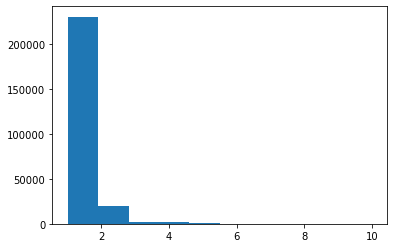

In [8]:
# get occurences
occurences = cosmic_muts[mutposname].value_counts().values
plt.hist(occurences[occurences <= 10])
print(np.quantile(occurences, 0.25), np.mean(occurences), np.median(occurences), np.quantile(occurences, 0.75))

In [9]:
# set threshold = at least 5 patients
threshold = 5
occ = cosmic_muts['chrom_pos'].value_counts() 
common_muts_occ = occ[occ >= threshold]
common_muts = list(common_muts_occ.index)
print(len(common_muts))

1069


In [15]:
# select only single chromosome
common_muts_chr = [c for c in common_muts if c.startswith('chr'+chrom)]
print(len(common_muts_chr))
# liftover hg38 -> hg19 for those common mutations in selected chr
common_muts_chr_liftover = np.copy(common_muts_chr)
### 15min of compute for chr22, 12hours of compute for all chromosomes ###
for i,c in enumerate(tqdm(common_muts_chr_liftover)):
    common_muts_chr_liftover[i] = liftover(c, 'data/extdata/hg38ToHg19.over.chain')
dict_liftover = dict(zip(common_muts_chr, common_muts_chr_liftover))
# dataframe for selected chr
cosmic_muts_chr = cosmic_muts[cosmic_muts['chrom'] == 'chr'+chrom] 
print(cosmic_muts_chr.shape)
cosmic_muts_chr['chrom_pos'].replace(dict_liftover, inplace=True)
# drop mutation positions with no coordinates in hg19
cosmic_muts_chr = cosmic_muts_chr[cosmic_muts_chr['chrom_pos'].str.startswith(chrom)]
print(cosmic_muts_chr.shape)
# reformat chr and pos with new coordinates
cosmic_muts_chr['chrom'] = cosmic_muts_chr['chrom_pos'].str.split('_').str[0]
cosmic_muts_chr['chrom'][cosmic_muts_chr['chrom'] == 'X'] = 23
cosmic_muts_chr['chrom'][cosmic_muts_chr['chrom'] == 'Y'] = 24
cosmic_muts_chr['chrom'] = cosmic_muts_chr['chrom'].astype(int)
cosmic_muts_chr['startpos'] = cosmic_muts_chr['chrom_pos'].str.split('_').str[1]
cosmic_muts_chr['startpos'] = cosmic_muts_chr['startpos'].astype(int)
cosmic_muts_chr['endpos'] = cosmic_muts_chr['chrom_pos'].str.split('_').str[2]
cosmic_muts_chr['endpos'] = cosmic_muts_chr['endpos'].astype(int)
cosmic_muts_chr.sort_values(by=['chrom', 'startpos', 'endpos'], axis=0, inplace=True)
cosmic_muts_chr.head()

25


chr22 22 [('chr22', 20118050, '+', 3231099988)] [('chr22', 20118050, '+', 3231099988)]
chr22 22 [('chr22', 23996204, '+', 3231099988)] [('chr22', 23996204, '+', 3231099988)]
chr22 22 [('chr22', 23996166, '+', 3231099988)] [('chr22', 23996167, '+', 3231099988)]
chr22 22 [('chr22', 21134385, '+', 3231099988)] [('chr22', 21134385, '+', 3231099988)]
chr22 22 [('chr22', 36057600, '+', 3231099988)] [('chr22', 36057600, '+', 3231099988)]
chr22 22 [('chr22', 38360420, '+', 3231099988)] [('chr22', 38360440, '+', 3231099988)]
chr22 22 [('chr22', 33189998, '+', 3231099988)] [('chr22', 33189998, '+', 3231099988)]
chr22 22 [('chr22', 38360372, '+', 3231099988)] [('chr22', 38360373, '+', 3231099988)]
chr22 22 [('chr22', 41962535, '+', 3231099988)] [('chr22', 41962536, '+', 3231099988)]
chr22 22 [('chr22', 19471048, '+', 3231099988)] [('chr22', 19471048, '+', 3231099988)]
chr22 22 [('chr22', 33651316, '+', 3231099988)] [('chr22', 33651317, '+', 3231099988)]
chr22 22 [('chr22', 19956494, '+', 32310999

/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Sample name,ID_SAMPLE,ID_tumour,Primary site,Site subtype 1,Site subtype 2,Site subtype 3,Primary histology,Histology subtype 1,Histology subtype 2,...,Whole_Genome_Reseq,Whole_Exome,ID_STUDY,PUBMED_PMID,HGVSG,type,chrom,startpos,endpos,chrom_pos
11796578,I2L-P24Ta-Tumor-Biopsy,2433483,2296364,large_intestine,colon,sigmoid,NS,carcinoma,adenocarcinoma,NS,...,n,y,NaN,25957691.0,22:g.19483525C>T,SNV,22,19471048,19471048,22_19471048_19471048
12433270,TCGA-AA-3833-01,1651042,1565829,large_intestine,colon,ascending,NS,carcinoma,adenocarcinoma,NS,...,n,y,376.0,22810696.0,22:g.19483525C>T,SNV,22,19471048,19471048,22_19471048_19471048
13410787,I2L-P24Tb-Tumor-Biopsy,2433484,2296365,large_intestine,colon,sigmoid,NS,carcinoma,adenocarcinoma,NS,...,n,y,NaN,25957691.0,22:g.19483525C>T,SNV,22,19471048,19471048,22_19471048_19471048
14724478,I2L-P24Ta-Tumor-Organoid,2433503,2296384,large_intestine,colon,sigmoid,NS,carcinoma,adenocarcinoma,NS,...,n,y,NaN,25957691.0,22:g.19483525C>T,SNV,22,19471048,19471048,22_19471048_19471048
15058455,PCRC13_1A,2873947,2728822,large_intestine,colon,ascending,NS,carcinoma,adenocarcinoma,NS,...,n,y,NaN,30038269.0,22:g.19483525C>T,SNV,22,19471048,19471048,22_19471048_19471048


In [16]:
if target == 'coding':
    # info about nomenclature http://varnomen.hgvs.org/recommendations/DNA/
    cosmic_muts_chr['ref'] = np.nan
    cosmic_muts_chr['alt'] = np.nan
    cosmic_muts_chr['ref'][cosmic_muts_chr['type'] == 'SNV'] = cosmic_muts_chr[cosmic_muts_chr['type'] == 'SNV']['Mutation CDS'].str.split('>').str[0].str[-1] 
    cosmic_muts_chr['alt'][cosmic_muts_chr['type'] == 'SNV'] = cosmic_muts_chr[cosmic_muts_chr['type'] == 'SNV']['Mutation CDS'].str.split('>').str[1]
    cosmic_muts_chr['alt'][cosmic_muts_chr['type'] == 'INS'] = cosmic_muts_chr[cosmic_muts_chr['type'] == 'INS']['Mutation CDS'].str.split('ins').str[1] 
    for ri, row in cosmic_muts_chr.iterrows():
        if (row['type'] == 'INS') and (row['Mutation CDS'].endswith('dup')):
            chrom, startpos, endpos = row['chrom_pos'].split('_')
            startpos, endpos = int(startpos), int(endpos)
            fasta = pysam.FastaFile(os.path.join('data', 'GRCh37', 'GRCh37.fa'))
            ref_seq = fasta.fetch(chrom, startpos-1, startpos)
            fasta.close()
            cosmic_muts_chr.at[ri, 'ref'] = ref_seq
            cosmic_muts_chr.at[ri, 'alt'] = ref_seq
    # needs shift in deletions for bamsurgeon to indicate length of deletion
    cosmic_muts_chr.loc[cosmic_muts_chr['type'] == 'DEL', 'endpos'] += 1 #cosmic_muts_chr[cosmic_muts_chr['type'] == 'DEL', 'endpos'] + 1
else: # target noncoding
    cosmic_muts_chr['ref'] = cosmic_muts_chr['WT_SEQ']
    cosmic_muts_chr['alt'] = cosmic_muts_chr['MUT_SEQ']
cosmic_muts_chr.head()

,Sample name,ID_SAMPLE,ID_tumour,Primary site,Site subtype 1,Site subtype 2,Site subtype 3,Primary histology,Histology subtype 1,Histology subtype 2,...,ID_STUDY,PUBMED_PMID,HGVSG,type,chrom,startpos,endpos,chrom_pos,ref,alt
11796578,I2L-P24Ta-Tumor-Biopsy,2433483,2296364,large_intestine,colon,sigmoid,NS,carcinoma,adenocarcinoma,NS,...,NaN,25957691.0,22:g.19483525C>T,SNV,22,19471048,19471048,22_19471048_19471048,C,T
12433270,TCGA-AA-3833-01,1651042,1565829,large_intestine,colon,ascending,NS,carcinoma,adenocarcinoma,NS,...,376.0,22810696.0,22:g.19483525C>T,SNV,22,19471048,19471048,22_19471048_19471048,C,T
13410787,I2L-P24Tb-Tumor-Biopsy,2433484,2296365,large_intestine,colon,sigmoid,NS,carcinoma,adenocarcinoma,NS,...,NaN,25957691.0,22:g.19483525C>T,SNV,22,19471048,19471048,22_19471048_19471048,C,T
14724478,I2L-P24Ta-Tumor-Organoid,2433503,2296384,large_intestine,colon,sigmoid,NS,carcinoma,adenocarcinoma,NS,...,NaN,25957691.0,22:g.19483525C>T,SNV,22,19471048,19471048,22_19471048_19471048,C,T
15058455,PCRC13_1A,2873947,2728822,large_intestine,colon,ascending,NS,carcinoma,adenocarcinoma,NS,...,NaN,30038269.0,22:g.19483525C>T,SNV,22,19471048,19471048,22_19471048_19471048,C,T


In [18]:
cosmic_bed_chr = cosmic_muts_chr[['chrom', 'startpos', 'endpos', 'alt', 'type']].reset_index(drop=True)
cosmic_bed_chr.drop_duplicates(inplace=True, ignore_index=True)
print(cosmic_bed_chr.shape)
print(cosmic_bed_chr[cosmic_bed_chr['type'] == 'INS'].head())
print(cosmic_bed_chr[cosmic_bed_chr['type'] == 'DEL'].head())
cosmic_bed_chr.head()

(197, 5)
     chrom  startpos    endpos alt type
29      22  23653979  23653980   G  INS
60      22  29095853  29095854   A  INS
63      22  29099530  29099531   A  INS
120     22  31969062  31969063   G  INS
155     22  40816548  40816549   G  INS
     chrom  startpos    endpos  alt type
39      22  24573703  24573704  NaN  DEL
67      22  29130546  29130547  NaN  DEL
104     22  30811811  30811812  NaN  DEL
124     22  32009712  32009713  NaN  DEL
157     22  41940067  41940068  NaN  DEL


,chrom,startpos,endpos,alt,type
0,22,17672573,17672573,T,SNV
1,22,17684453,17684453,A,SNV
2,22,17684501,17684501,A,SNV
3,22,17688140,17688140,T,SNV
4,22,18210204,18210204,C,SNV


In [19]:
# check for errors
# SNV
print(sum(cosmic_bed_chr[cosmic_bed_chr['type'] == 'SNV']['endpos'] != cosmic_bed_chr[cosmic_bed_chr['type'] == 'SNV']['startpos']))
# INS
print(sum(cosmic_bed_chr[cosmic_bed_chr['type'] == 'INS']['endpos'] - cosmic_bed_chr[cosmic_bed_chr['type'] == 'INS']['startpos'] != cosmic_bed_chr[cosmic_bed_chr['type'] == 'INS']['alt'].str.len()))
print(sum(cosmic_bed_chr[cosmic_bed_chr['type'] == 'INS']['endpos'] - cosmic_bed_chr[cosmic_bed_chr['type'] == 'INS']['startpos'] <= 0))
# DEL
print(sum(cosmic_bed_chr[cosmic_bed_chr['type'] == 'DEL']['startpos'] - cosmic_bed_chr[cosmic_bed_chr['type'] == 'DEL']['endpos'] >= 0))

0
0
0
0


22    185
Name: chrom, dtype: int64
22    12
Name: chrom, dtype: int64


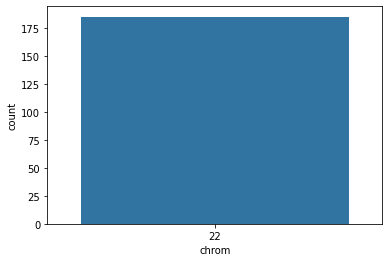

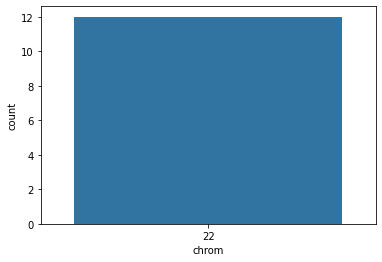

In [20]:
sns.countplot(x='chrom', data=cosmic_bed_chr[cosmic_bed_chr['type'] == 'SNV'])
print(cosmic_bed_chr[cosmic_bed_chr['type'] == 'SNV']['chrom'].value_counts().sort_index())
plt.figure()
sns.countplot(x='chrom', data=cosmic_bed_chr[(cosmic_bed_chr['type'] == 'INS') | (cosmic_bed_chr['type'] == 'DEL')])
print(cosmic_bed_chr[(cosmic_bed_chr['type'] == 'INS') | (cosmic_bed_chr['type'] == 'DEL')]['chrom'].value_counts().sort_index())

# Save for SNV and INDEL bedfile for bamsurgeon

In [21]:
### /!\ 1-based index for SNV bamsurgeon
cosmic_bed_chr_snv = cosmic_bed_chr[cosmic_bed_chr['type'] == 'SNV'].drop('type', axis=1)
cosmic_bed_chr_snv.insert(loc = 3, column = 'vaf', value = 1)  # Insert default VAF column
cosmic_bed_chr_snv

,chrom,startpos,endpos,vaf,alt
0,22,17672573,17672573,1,T
1,22,17684453,17684453,1,A
2,22,17684501,17684501,1,A
3,22,17688140,17688140,1,T
4,22,18210204,18210204,1,C
...,...,...,...,...,...
191,22,51010669,51010669,1,T
192,22,51011322,51011322,1,T
193,22,51011401,51011401,1,A
194,22,51063680,51063680,1,A


In [22]:
### /!\ 0-based index for INDEL bamsurgeon
cosmic_bed_chr_indel = cosmic_bed_chr[(cosmic_bed_chr['type'] == 'INS') | (cosmic_bed_chr['type'] == 'DEL')].drop('type', axis=1)
cosmic_bed_chr_indel.insert(loc = 3, column = 'vaf', value = 1)  # Insert default VAF column
cosmic_bed_chr_indel['startpos'] -= 1
cosmic_bed_chr_indel['endpos'] -= 1
cosmic_bed_chr_indel

,chrom,startpos,endpos,vaf,alt
29,22,23653978,23653979,1,G
39,22,24573702,24573703,1,NaN
60,22,29095852,29095853,1,A
63,22,29099529,29099530,1,A
67,22,29130545,29130546,1,NaN
104,22,30811810,30811811,1,NaN
120,22,31969061,31969062,1,G
124,22,32009711,32009712,1,NaN
155,22,40816547,40816548,1,G
157,22,41940066,41940067,1,NaN


In [23]:
# save bed files 
cosmic_bed_chr_snv.to_csv('data/spikein/spikein_chr'+chrom+'/common_cancer_mutations/'+cancer_type+'_chr'+chrom+'_SNV_tf1.bed', sep='\t', header=False, index=False)
cosmic_bed_chr_indel.to_csv('data/spikein/spikein_chr'+chrom+'/common_cancer_mutations/'+cancer_type+'_chr'+chrom+'_INDEL_tf1.bed', sep='\t', header=False, index=False)